In [1]:
def dVm_dt_max(time, values, info):
    
    dt = time[1]-time[0]
    max_dV = (values[1]-values[0])/dt
    for i in range((np.shape(values)[0])-2):
        temp = (values[i+2]-values[i+1])/dt
        #print(temp)
        #print()
        if(temp > max_dV):
            max_dV = temp
    
    values_feature = max_dV
    
    #return time_feature, values_feature
    return None, values_feature

def V_max(time, values, info):
    
    values_feature = np.max(values)
    
    #return time_feature, values_feature
    return None, values_feature

def APD_50(time, values, info): 
    
    delta_V = np.max(values) - values[0]
    delta_V_50 = np.max(values) - delta_V*0.5
    delta_time_50 = time[-1] # Nel caso in cui non lo raggiunga (da sistemare, anche i parametri)
    pol=10 # (better to fix) just to be sure i already passed zero during polarization

    for i in range((np.shape(values)[0])-10):
        if(values[i+pol]<=delta_V_50):
            delta_time_50 = time[i+pol]
            break
            
    values_feature = delta_time_50   
            
    return None, values_feature

def APD_90(time, values, info): 
    
    delta_V = np.max(values) - values[0]
    delta_V_90 = np.max(values) - delta_V*0.9
    delta_time_90 = time[-1]
    pol=10 # (better to fix) just to be sure i already passed zero during polarization

    for i in range((np.shape(values)[0])-10):
        if(values[i+pol]<=delta_V_90):
            delta_time_90 = time[i+pol]
            break
    
    values_feature = delta_time_90
            
    return None, values_feature

def V_20(time, values, info):
    
    toi = APD_90(time, values, info)[1]*0.2 #time of interest
    pol=10 # (better to fix) just to be sure i already passed zero during polarization
    values_feature=0
    
    for i in range((np.shape(values)[0])-10):
        if(time[i+pol]>=toi):
            values_feature = values[i+pol]
            break
    
    #return time_feature, values_feature
    return None, values_feature

def V_40(time, values, info):
    
    toi = APD_90(time, values, info)[1]*0.4 #time of interest
    pol=10 # (better to fix) just to be sure i already passed zero during polarization
    values_feature=0
    
    for i in range((np.shape(values)[0])-10):
        if(time[i+pol]>=toi):
            values_feature = values[i+pol]
            break
    
    #return time_feature, values_feature
    return None, values_feature

def V_60(time, values, info):
    
    toi = APD_90(time, values, info)[1]*0.6 #time of interest
    pol=10 # (better to fix) just to be sure i already passed zero during polarization
    values_feature=0
    
    for i in range((np.shape(values)[0])-10):
        if(time[i+pol]>=toi):
            values_feature = values[i+pol]
            break
    
    #return time_feature, values_feature
    return None, values_feature

def V_80(time, values, info):
    
    toi = APD_90(time, values, info)[1]*0.8 #time of interest
    pol=10 # (better to fix) just to be sure i already passed zero during polarization
    values_feature=0
    
    for i in range((np.shape(values)[0])-10):
        if(time[i+pol]>=toi):
            values_feature = values[i+pol]
            break
    
    #return time_feature, values_feature
    return None, values_feature

def rest_Vm(time, values, info):
    
    # Da modificare quando si capisce e si modifica l'intervallo di tempo su cui operare
    values_feature = values[-1] # ultimo valore per ora
    
    #return time_feature, values_feature
    return None, values_feature

def Ca2_max(time, values, info):
    
    return None, values_feature

def get_all_keys_in_order(list_of_dicts):
    ordered_keys = []
    for dict_ in list_of_dicts:
        for key in dict_:
            if key not in ordered_keys:
                ordered_keys.append(key)
    return ordered_keys

In [6]:
import uncertainpy as un
import chaospy as cp
import numpy as np

from maleckar import maleckar_model

# Initialize the model
model = un.Model(run=maleckar_model,
                 labels=["Time (ms)", "Membrane potential (mV)"])

# Define a parameter dictionary
parameters_list = {
    #"V_0": -74.031982,
    "PNa": 0.0018,
    "GK1": 3.1,
    "Gt": 8.25,
    "GKur": 2.25,
    "GKr": 0.5,
    "GKs": 1.0,
    "GCa_L": 6.75,
    "Gb_Na": 0.0605,
    "Gb_Ca": 0.0590,
    "NaKMax": 68.55,
    "KNaCa": 0.0750,
    "ip_CaMax": 4.0,
    "alpha_rel": 200000,
    "tao_tr": 0.01,
    "iupMax": 2800,
    "Kcyca": 0.0003,
    "Ksrca": 0.5, 
    "Kxcs": 0.4,
    "Cm": 50,
    "conc_Na": 140.0,
    "conc_Ca2": 5.4,
    "conc_K": 1.8
}

# Create the parameters
parameters = un.Parameters(parameters_list)

# Set all parameters to have a uniform distribution
# within a 50% interval around their fixed value
parameters.set_all_distributions(un.uniform(0.5))

feature_functions = [dVm_dt_max, V_max, V_20, V_40, V_60, V_80, APD_50, APD_90, rest_Vm]

features = un.Features(
    new_features=feature_functions,
    features_to_run="all"
)

# Perform the uncertainty quantification
UQ = un.UncertaintyQuantification(model,
                                  parameters=parameters,
                                  features=features)


In [ ]:
# We set the seed to easier be able to reproduce the result
data = UQ.quantify(seed=10,
                   method="mc",
                   nr_mc_samples=32768
                  )

# Con istante finale = 0.5 (ms???) ci mette 20 minuti (100 timesteps)

In [4]:
data = un.Data()
data.load("data/maleckar_model.h5")
data

In [6]:
vector = data["V_max"].sobol_first

min_value = np.min(vector)
max_value = np.max(vector)

vector = (vector - min_value) / (max_value - min_value)

def softmax(x):
    """Calcola la funzione softmax per un vettore x."""
    exp_x = np.exp(x)
    sum_exp_x = np.sum(exp_x)
    return exp_x / sum_exp_x

norm_vector = softmax(vector)

normalized_vector = softmax(data["V_max"].sobol_first)

In [8]:
norm_vector

array([0.09633266, 0.04333653, 0.03690664, 0.05707701, 0.04296464,
       0.04297249, 0.0424935 , 0.04289932, 0.04297846, 0.04333509,
       0.04273191, 0.04314818, 0.04294155, 0.04296724, 0.04296035,
       0.04346054, 0.04287908, 0.04327034, 0.0354388 , 0.04296914,
       0.042976  , 0.04296053])

In [10]:
print(data.data["V_max"].sobol_first)
print(data["V_max"].sobol_first)

[1.3035955120170226, 0.013574688253470203, -0.24578932283208957, 0.4583339604174167, -0.00034335517297135934, -4.827069600829452e-05, -0.01815013151388628, -0.0028004708868935436, 0.00017603064888433988, 0.01352120004049986, -0.009114868986997048, 0.00654056138665288, -0.0012113780144688735, -0.00024560202200147056, -0.0005045514027434048, 0.01818941071354701, -0.003562705254485413, 0.011106336442874298, -0.3113296641167592, -0.00017408230327694966, 8.372605181802031e-05, -0.0004977993209537059]
[1.3035955120170226, 0.013574688253470203, -0.24578932283208957, 0.4583339604174167, -0.00034335517297135934, -4.827069600829452e-05, -0.01815013151388628, -0.0028004708868935436, 0.00017603064888433988, 0.01352120004049986, -0.009114868986997048, 0.00654056138665288, -0.0012113780144688735, -0.00024560202200147056, -0.0005045514027434048, 0.01818941071354701, -0.003562705254485413, 0.011106336442874298, -0.3113296641167592, -0.00017408230327694966, 8.372605181802031e-05, -0.0004977993209537059

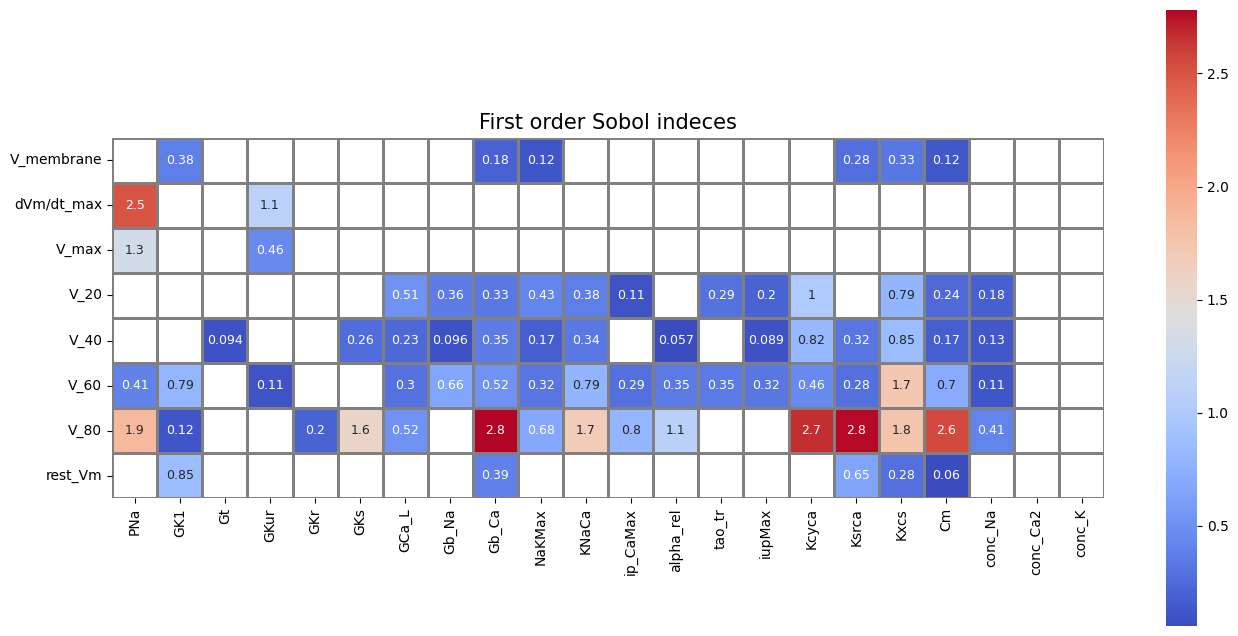

In [26]:
### SOBOL FIRST ###

import pandas as pd
matrix = np.array([data["V_max"].sobol_first, data["dVm_dt_max"].sobol_first])
matrix

df = pd.DataFrame({'V_membrane':data["maleckar_model"].sobol_first_average, 
                   'dVm/dt_max':data["dVm_dt_max"].sobol_first_average, 
                   'V_max':data["V_max"].sobol_first,
                   'V_20':data["V_20"].sobol_first,
                   'V_40':data["V_40"].sobol_first,
                   'V_60':data["V_60"].sobol_first,
                   'V_80':data["V_80"].sobol_first,
                   #'APD_50':data["APD_50"].sobol_first, 
                   #'APD_90':data["APD_90"].sobol_first,
                   'rest_Vm':data["rest_Vm"].sobol_first})
df = df.transpose()
df.columns = get_all_keys_in_order([parameters_list])

import seaborn as sns
import matplotlib.pylab as plt

fig, ax = plt.subplots(figsize=(16, 8))
mask = np.array(df < 0.05)

ax = sns.heatmap(df, linewidth=0.8, annot=True, square=True, ax=ax, 
                 cmap='coolwarm', annot_kws={"fontsize": 9}, mask=mask,
                 linecolor='grey')
ax.set_title("First order Sobol indeces", fontsize=15)

plt.show()

# PROBLEMA --> I Sobol index sono anche negativi ???? 

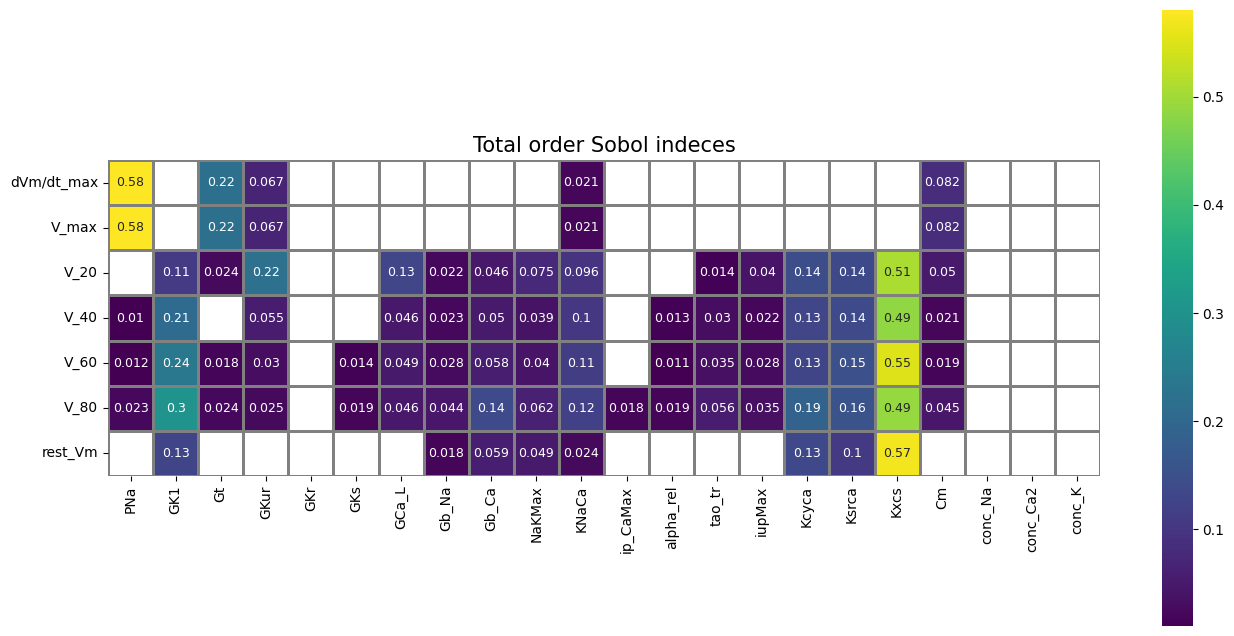

In [33]:
### SOBOL TOTAL ###

import pandas as pd
matrix = np.array([data["V_max"].sobol_first, data["dVm_dt_max"].sobol_first])
matrix

df = pd.DataFrame({'dVm/dt_max':data["dVm_dt_max"].sobol_total, 
                   'V_max':data["V_max"].sobol_total,
                   'V_20':data["V_20"].sobol_total,
                   'V_40':data["V_40"].sobol_total,
                   'V_60':data["V_60"].sobol_total,
                   'V_80':data["V_80"].sobol_total,
                   #'APD_50':data["APD_50"].sobol_total, 
                   #'APD_90':data["APD_90"].sobol_total,
                   'rest_Vm':data["rest_Vm"].sobol_total})
df = df.transpose()
df.columns = get_all_keys_in_order([parameters_list])

import seaborn as sns
import matplotlib.pylab as plt

fig, ax = plt.subplots(figsize=(16, 8))
mask = np.array(abs(df) < 0.01)

ax = sns.heatmap(df, linewidth=0.8, annot=True, square=True, ax=ax, 
                 cmap='viridis', annot_kws={"fontsize": 9}, mask=mask,
                 linecolor='grey')
ax.set_title("Total order Sobol indeces", fontsize=15)

plt.show()

In [ ]:
df

In [ ]:
print(data["APD_50"].evaluations)

In [18]:
time, values, info = maleckar_model( #V_0=-74.031982,
                    PNa=0.0018,
                    GK1=3.1,
                    Gt=8.25,
                    GKur=2.25,
                    GKr=0.5,
                    GKs=1.0,
                    GCa_L=6.75,
                    Gb_Na=0.0605,
                    Gb_Ca=0.0590,
                    NaKMax=68.55,
                    KNaCa=0.0750,
                    ip_CaMax=4.0,
                    alpha_rel=200000,
                    tao_tr=0.01,
                    iupMax=2800,
                    Kcyca=0.0003,
                    Ksrca=0.5, 
                    Kxcs=0.4,
                    Cm=50,
                    conc_Na=140.0,
                    conc_Ca2=5.4,
                    conc_K=1.8 )
#print(time)
#print(values)
#print(info)
print(np.shape(time))
print(np.shape(values))

(100,)
(100,)
